<a href="https://colab.research.google.com/github/GerrardE/histopathologic-cancer-detection/blob/ft-sequential-cancer-detection/Sequential_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob, os, shutil
import tensorflow as tf
import pandas as pd
import numpy as np
import itertools

from sklearn.utils import shuffle
from google.colab import drive, files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import  ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers.legacy import Nadam
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

In [2]:
!rm -rf dataset model.h5 sample_data base_dir *.csv *.json && mkdir dataset

In [3]:
!pip install -q kaggle

files.upload()

!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!sudo chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c histopathologic-cancer-detection && kaggle datasets list

Saving kaggle.json to kaggle.json
100% 6.31G/6.31G [03:02<00:00, 43.7MB/s]
100% 6.31G/6.31G [03:02<00:00, 37.1MB/s]
ref                                                      title                                     size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  ---------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide     Covid Cases and Deaths WorldWide           8KB  2023-02-01 12:22:51          13213        448  1.0              
datascientistanna/customers-dataset                      Shop Customer Data                        23KB  2023-02-07 18:42:21          11429        261  1.0              
ulrikthygepedersen/co2-emissions-by-country              CO2 Emissions                            114KB  2023-02-28 12:39:49           1299         33  1.0              
amaanansari09/most-streamed-songs-

In [4]:
!unzip './histopathologic-cancer-detection.zip' -d './dataset'

Streaming output truncated to the last 5000 lines.
  inflating: ./dataset/train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: ./dataset/train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: ./dataset/train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: ./dataset/train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: ./dataset/train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: ./dataset/train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: ./dataset/train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: ./dataset/train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: ./dataset/train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: ./dataset/train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: ./dataset/train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: ./dataset/train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: ./dataset/train/fa2ebf31

In [5]:
# Visualize dataset
# Reference: https://www.kaggle.com/code/taylorkern/tk-hcd-vgg19

def display_images(df):
  train_path = "./dataset/train"

  sample = df.sample(n=16).reset_index()

  plt.figure(figsize=(6,6))

  for i, row in sample.iterrows():

      img = mpimg.imread(f'./dataset/train/{row.id}.tif')    
      label = row.label

      plt.subplot(4,4,i+1)
      plt.imshow(img)
      plt.text(0, -5, f'Class {label}', color='k')
          
      plt.axis('off')

  plt.tight_layout()
  plt.show()

In [6]:
# Read .csv files folder
path = './dataset'

train_csv_file = path + '/train_labels.csv'

def process_images(csv_path, train_dir, val_dir, sample_size):
  df = pd.read_csv(csv_path)

  display_images(pd.read_csv(csv_path))

  df_1 = df[df['label'] == 0].sample(sample_size, random_state=10)
  df_2 = df[df['label'] == 1].sample(sample_size, random_state=10)
  
  df = pd.concat([df_1, df_2], axis=0).reset_index(drop=True)

  shuffled_df = shuffle(df)

  df.set_index('id', inplace=True)

  y = shuffled_df['label']

  train_df, val_df = train_test_split(shuffled_df, test_size=0.20, random_state=10, stratify=y)

  df_list_train = list(train_df['id'])

  for item in df_list_train:
    target=df.loc[item, 'label']

    if target == 1:
      imagelabel = 'tumor'
    if target == 0:
      imagelabel = 'notumor'

    src=os.path.join('./dataset/train', item+'.tif')
    dst=os.path.join(train_dir, imagelabel, item+'.tif')

    try:
      shutil.copyfile(src, dst)
    except FileNotFoundError:
      continue

  df_list_val = list(val_df['id'])

  for item in df_list_val:
    target=df.loc[item, 'label']

    if target == 1:
      imagelabel = 'tumor'
    if target == 0:
      imagelabel = 'notumor'

    src=os.path.join('./dataset/train', item+'.tif')
    dst=os.path.join(val_dir, imagelabel, item+'.tif')

    try:
      shutil.copyfile(src, dst)
    except FileNotFoundError:
      continue
  
  # return the dataframe
  return train_df, val_df


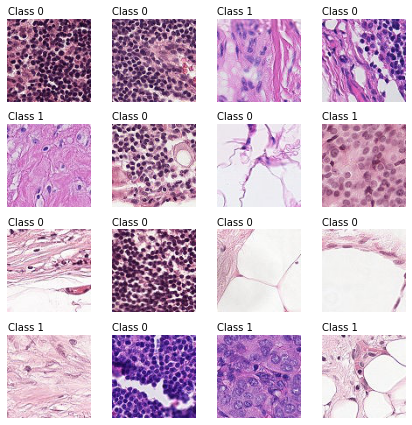

Number of tumor train images 40000
Number of notumor train images 40000


Number of tumor val images 10000
Number of notumor val images 10000


In [7]:
# make the base directory 
base_dir = 'base_dir'
os.mkdir(base_dir)

# Create a train directory
train_dir = 'base_dir/train_dir'
os.mkdir(train_dir)

tumor = os.path.join(train_dir, 'tumor')
os.mkdir(tumor)
notumor = os.path.join(train_dir, 'notumor')
os.mkdir(notumor)

# Create a val directory
val_dir = 'base_dir/val_dir'
os.mkdir(val_dir)

tumor = os.path.join(val_dir, 'tumor')
os.mkdir(tumor)
notumor = os.path.join(val_dir, 'notumor')
os.mkdir(notumor)

# Sample images and move them to their respective validation and train directories
train_df, val_df = process_images(train_csv_file, train_dir, val_dir, 50000)

print('Number of tumor train images', len(os.listdir('base_dir/train_dir/tumor')))
print('Number of notumor train images', len(os.listdir('base_dir/train_dir/notumor')))
print('\n')
print('Number of tumor val images', len(os.listdir('base_dir/val_dir/tumor')))
print('Number of notumor val images', len(os.listdir('base_dir/val_dir/notumor')))

In [8]:
# Ready the Generators
image_size=96

train_sample_count=len(os.listdir('base_dir/train_dir/tumor'))+len(os.listdir('base_dir/train_dir/notumor'))
val_sample_count=len(os.listdir('base_dir/val_dir/tumor'))+len(os.listdir('base_dir/val_dir/notumor'))

train_batch_size=14
val_batch_size=14
val_unshuffled_batch_size=1

train_steps = np.floor(train_sample_count / train_batch_size)
val_steps = np.floor(val_sample_count / val_batch_size)

datagen=ImageDataGenerator(rescale=1.0/255)

train_gen=datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=train_batch_size,
    class_mode='categorical'
)

val_gen=datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    class_mode='categorical'
)

val_gen_unshuffled=datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=val_unshuffled_batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [9]:
# Utilize a CNN architecture/ Define The Model
# Reference https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-5min-0-8253-lb

kernel_size=(3,3)
pool_size= (2,2)
dropout_conv=0.3
dropout_dense=0.5

first_filters=32
second_filters=64
third_filters=128

input_shape=(image_size, image_size, 3)

model=Sequential()
model.add(Conv2D(first_filters, kernel_size, activation='relu', input_shape=input_shape))
model.add(Conv2D(first_filters, kernel_size, activation ='relu'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation="softmax"))

model.compile(Nadam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 92, 92, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 92, 92, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 46, 46, 32)        0

In [10]:
# Train the Model
filepath = "sequential_model.h5"

checkpoint=ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_lr=ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=1, verbose=1, mode='max', min_lr=0.00001)
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(
                    train_gen, 
                    steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=25,
                    verbose=1,
                    callbacks=callbacks_list
                    )

Epoch 1/25
5712/5714 [============================>.] - ETA: 0s - loss: 0.4768 - accuracy: 0.7889
Epoch 1: val_accuracy improved from -inf to 0.83658, saving model to model.h5
5714/5714 [==============================] - 192s 32ms/step - loss: 0.4769 - accuracy: 0.7889 - val_loss: 0.3830 - val_accuracy: 0.8366 - lr: 1.0000e-04
Epoch 2/25
5712/5714 [============================>.] - ETA: 0s - loss: 0.3977 - accuracy: 0.8307
Epoch 2: val_accuracy did not improve from 0.83658

Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
5714/5714 [==============================] - 174s 30ms/step - loss: 0.3978 - accuracy: 0.8307 - val_loss: 0.4694 - val_accuracy: 0.7931 - lr: 1.0000e-04
Epoch 3/25
5714/5714 [==============================] - ETA: 0s - loss: 0.3521 - accuracy: 0.8525
Epoch 3: val_accuracy improved from 0.83658 to 0.85304, saving model to model.h5
5714/5714 [==============================] - 154s 27ms/step - loss: 0.3521 - accuracy: 0.8525 - val_loss: 0.3698 

In [11]:
model.load_weights('model.h5')
model.metrics_names
val_loss, val_acc = model.evaluate(val_gen_unshuffled, steps=val_sample_count, verbose=1)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

20000/20000 [==============================] - 88s 4ms/step - loss: 0.2112 - accuracy: 0.9207
val_loss: 0.2111945003271103
val_acc: 0.9206500053405762


<Figure size 432x288 with 0 Axes>

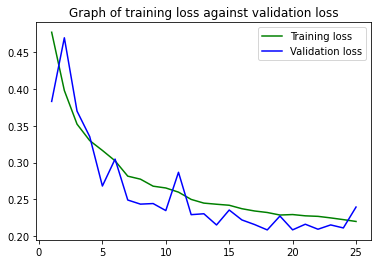

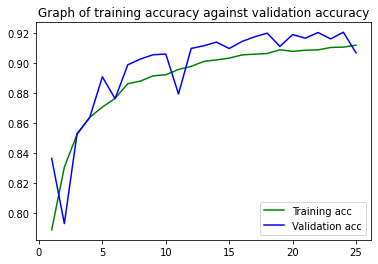

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt

acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]

epochs=range(1, len(acc)+1)

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Graph of training loss against validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Graph of training accuracy against validation accuracy')
plt.legend()
plt.figure()

In [13]:
# make predictions using the test images
predictions=model.predict(val_gen_unshuffled, steps=val_sample_count, verbose=1)
predictions.shape
pred_df=pd.DataFrame(predictions, columns=['notumor', 'tumor'])

pred_df.head()

# Retrieve the true labels
y_true=val_gen_unshuffled.classes

# Retrieve the AUC score
y_pred=pred_df['tumor']

roc_auc_score(y_true, y_pred)

20000/20000 [==============================] - 71s 4ms/step


0.9723807649999998

In [14]:
# Reference: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[9321  679]
 [ 908 9092]]


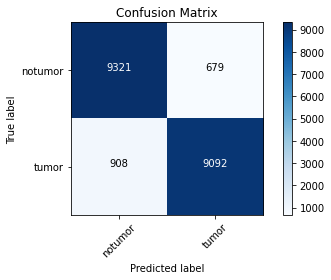

In [15]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix

test_labels=val_gen_unshuffled.classes
test_labels.shape

conf_matrix=confusion_matrix(test_labels, predictions.argmax(axis=1))
conf_matrix_plot_labels=['notumor', 'tumor']

plot_confusion_matrix(conf_matrix, conf_matrix_plot_labels, title='Confusion Matrix')

In [16]:
# Prepare classification report

from sklearn.metrics import classification_report

y_pred_binary=predictions.argmax(axis=1)

report=classification_report(y_true, y_pred_binary, target_names=conf_matrix_plot_labels)

print(report)

              precision    recall  f1-score   support

     notumor       0.91      0.93      0.92     10000
       tumor       0.93      0.91      0.92     10000

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



In [17]:
def process_test_images(test_dir, test_images):
  count=5000

  for image in test_images:
    if(count != 0):
      src=os.path.join('./dataset/test', image)
      dst=os.path.join(test_dir, image)

      try:
        shutil.copyfile(src, dst)
        count-=1
      except FileNotFoundError:
        continue
    else:
      break;


In [18]:
!rm -rf './base_dir/test_dir'

# Create a test directory
test_base_dir = './base_dir/test_dir'
os.mkdir(test_base_dir)
test_dir = './base_dir/test_dir/images'
os.mkdir(test_dir)

process_test_images(test_dir, os.listdir('./dataset/test'));

test_gen=datagen.flow_from_directory(
    test_base_dir,
    target_size=(image_size, image_size),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

test_image_count=len(os.listdir(test_dir))
model.load_weights('sequential_model.h5')

predictions=model.predict(test_gen, steps=test_image_count, verbose=1)

pred_df=pd.DataFrame(predictions, columns=['notumor', 'tumor'])

test_filenames=test_gen.filenames
pred_df['filename']=test_filenames
pred_df.head()

Found 5000 images belonging to 1 classes.
5000/5000 [==============================] - 18s 4ms/step


,notumor,tumor,filename
0,0.006692,0.993308,images/0010e7eaa3d8e14203cd3900b739d8bf0f0b67f...
1,0.935504,0.064496,images/003c82a3fd4d552af6da029f09ed1824894fd6f...
2,0.000498,0.999502,images/003d14ca5481028a008c34b6cca7c235dcc1d29...
3,0.000138,0.999861,images/005378cea8f2e0338f45d7cc77f3d60e4292725...
4,0.005486,0.994514,images/0058dab0652de23878eef583f4635b19b59dc59...


In [19]:
def extract_filename(strg):
  str1=strg.split('/')
  return str1[1]

pred_df['filename']=pred_df['filename'].apply(extract_filename)

y_pred = pred_df['tumor']
filename=pred_df['filename']

# Create a submission file
submission=pd.DataFrame({
    'filename': filename,
    'class': y_pred, 
}).set_index('filename')

submission.to_csv('sequential_preds.csv', columns=['class'])

submission.tail()

,class
filename,
ff50793ad6d8838830b47e5f71627e7dea7d4875.tif,0.194760
ff5c337a8be7667d59d5b143afcba9f797e5b923.tif,0.000048
ff84572a68341ce9c071fd2d047b4498cda5ae57.tif,0.990088
ff93232c91aaa7884c0ced38f3438ac50cc6e941.tif,0.006097
ffd830b397c1a03c35688ccf898667832cff89f8.tif,0.996564
